In [1]:
# In this assingnment, we will be using Pandas dataframes
# to read, transform, and store MNIST images. Make sure
# you are familiar with its API:
# https://pandas.pydata.org/pandas-docs/stable/

import pandas as pd

In [2]:
# Enter here the Dataset ID that you have received in the spreadsheet.
# Make sure that you use the ID that was assigned to you, 
# otherwise your submission will be graded against the wrong images.
dataset_id = '20220924-233421_a7f2ab939f7b370bd21958bc33055f53'

# Assignment datasets are stored in an AWS S3 bucket. The following code
# downloads your dataset (~300MB) directly into RAM. Optionally,
# you can save the datasets to the local disk, but that's really not required.
prefix = f'https://danylo-ucla.s3-us-west-2.amazonaws.com/app/storage/mnist/jobs/transform_repack/{dataset_id}'

# These three dataframes contain clean images. Use each dataframe
# to train, validate, and test your model, respectively.
train_clean_X = pd.read_parquet(f'{prefix}/train_clean_x.parquet')
validate_clean_X = pd.read_parquet(f'{prefix}/validate_clean_x.parquet')
test_clean_X = pd.read_parquet(f'{prefix}/test_clean_x.parquet')

# These dataframes are noisy versions of the dataframes above.
train_noisy_X = pd.read_parquet(f'{prefix}/train_noisy_x.parquet')
validate_noisy_X = pd.read_parquet(f'{prefix}/validate_noisy_x.parquet')
test_noisy_X = pd.read_parquet(f'{prefix}/test_noisy_x.parquet')

# This is the segment of the dataset that will be graded in this assignment.
# Your model has to denoise this dataframe, and you have to submit the denoised version of this dataframe.
score_noisy_X = pd.read_parquet(f'{prefix}/score_noisy_x.parquet')

# For additional context, these are labels (e.g. digits) corresponding
# to each image in the dataset. Use it to analyze which digits
# your models has more or less problems with. These dataframes
# should not be used as part of the training process itself,
# only for post-training analysis, if you wish so.
train_y = pd.read_parquet(f'{prefix}/train_y.parquet')
validate_y = pd.read_parquet(f'{prefix}/validate_y.parquet')
test_y = pd.read_parquet(f'{prefix}/test_y.parquet')

In [3]:
# While not strictly required for this assignment,
# you will probably want to plot images to
# have a visual understanding of the model's performance.
# You can use any Python plotting library, for example:
# https://matplotlib.org/contents.html

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [4]:
import numpy as np

# The example in this notebook trains an undercomplete
# autoencoder and uses it for anomaly detection.
# An anomaly is defined as an image with Gaussian noise.
# Therefore, the label is 1 if the image came from the noisy dataset.

def combine_anomaly_dataset(clean_X: np.ndarray, noisy_X: np.ndarray) -> np.ndarray:
    anomaly_y = np.hstack([
        np.repeat(0, clean_X.shape[0]),  # label
        np.repeat(1, noisy_X.shape[0]),  # label
    ])

    anomaly_X = np.vstack([
        clean_X,  # data
        noisy_X,  # data
    ])

    return anomaly_X, anomaly_y


train_anomaly_X, train_anomaly_y = combine_anomaly_dataset(train_clean_X, train_noisy_X)
validate_anomaly_X, validate_anomaly_y = combine_anomaly_dataset(validate_clean_X, validate_noisy_X)
train_anomaly_X.shape, validate_anomaly_X.shape, train_anomaly_y.shape

((98000, 784), (14000, 784), (98000,))

In [5]:
# Just as in the lecture slides, the input matrix
# has row vectors that hold pixels of a single 28x28 image.
# Note that the column vectors are individual locations on
# the 28x28 grid, but flattened in a row-major way (28x28=784).
train_clean_X.shape

(49000, 784)

In [6]:
example_id = 1

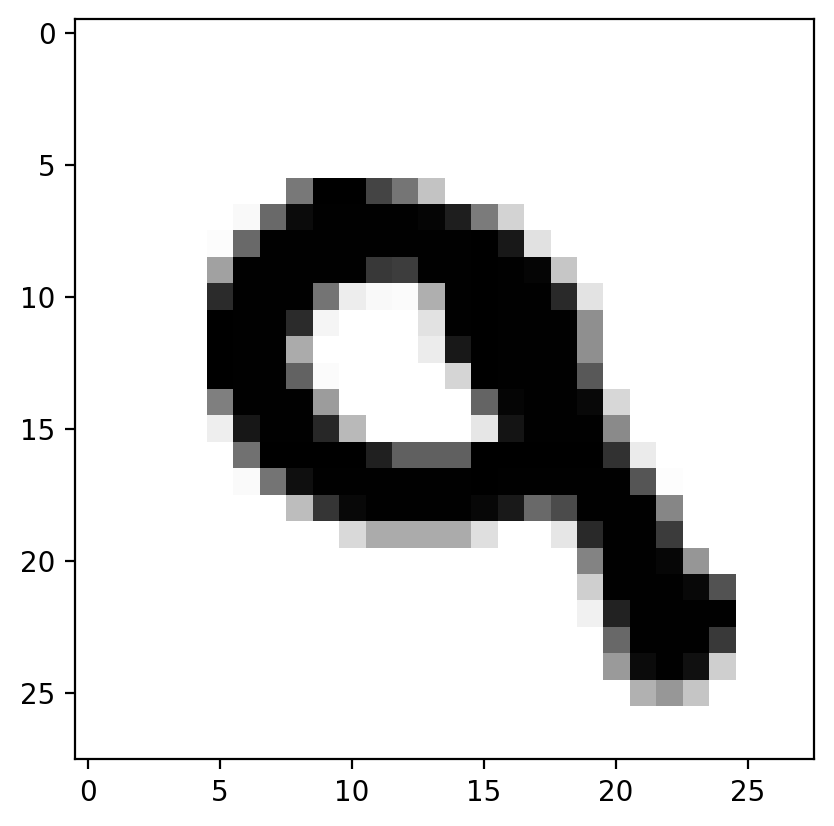

In [7]:
# Let's select a clean image from the dataset
image_pixels = train_clean_X.iloc[example_id]

# In order to plot an image, you need to reshape
# the flattened array back into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')

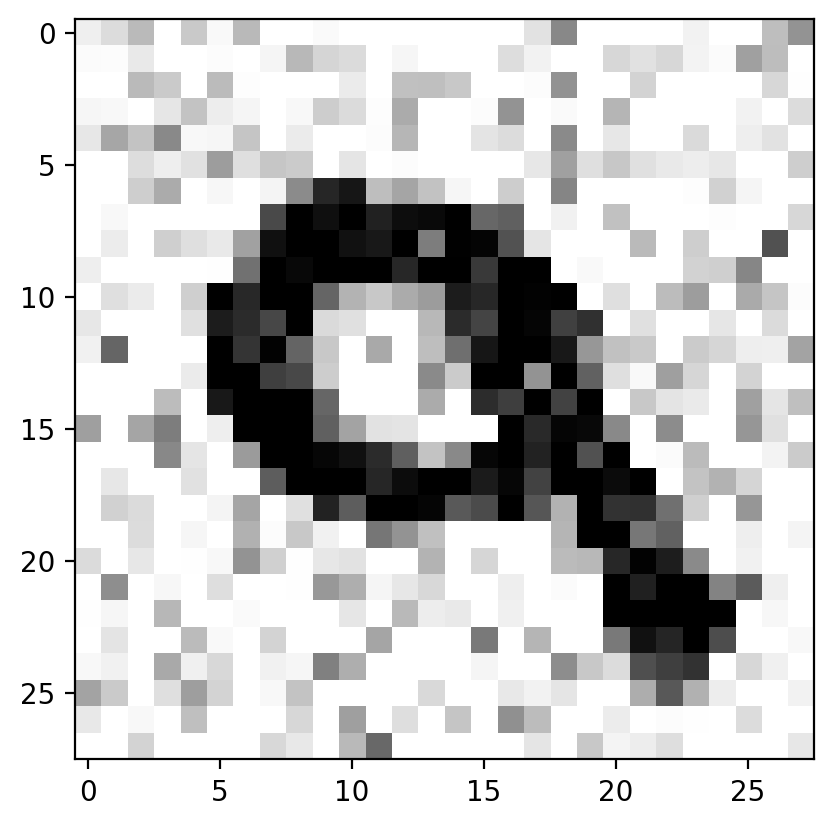

In [8]:
# Let's select a noisy image from the dataset
image_pixels = train_noisy_X.iloc[example_id]

# In order to plot an image, you need to reshape
# the flattened array back into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')

In [9]:
train_y.iloc[example_id]

digit    9
Name: 1, dtype: uint8

In [10]:
# Run this cell to configure Tensorflow to use your GPU
import tensorflow as tf
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

In [11]:
# In this couse, all assignments are expected to be
# implemented with Tensorflow framework.
# For this task, we can use its high-level Keras API:
# https://keras.io

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers


def build_model(encoder_width: int, learning_rate_log: float) -> tf.keras.Model:
    mlflow.log_param('encoder_width', encoder_width)
    mlflow.log_param('learning_rate_log', learning_rate_log)
    
    # IMPORTANT: This is an example of a very simple undercomplete autoencoder.
    # In other words, you will probably need to tweak these lines of code.
    
    layers = [
        # Encoder: 50 nodes, Exponential Linear Unit activation
        Dense(
            units=encoder_width, 
            activation='gelu', 
            input_shape=(28 * 28,)
        ),

        # Decoder: matches the shape of the image
        # Sigmoid activation is needed because pixel
        # values are real numbers between 0 (dark) and 1 (bright).
        Dense(units=28*28, activation='sigmoid')
    ]

    # Sequential class is a Keras class that attaches every 
    # layer's output to the next layer's input.
    # This is essentially a helper class for any feedforward networks.
    autoencoder = Sequential(layers)

    # Using MSE as the loss function, and Adam optimizer.
    # Other optimizers can also be used.
    autoencoder.compile(
        optimizer=optimizers.Adam(
            learning_rate=10 ** learning_rate_log
        ), 
        loss='mean_squared_error',
    )
    return autoencoder

In [12]:
import json
import uuid
import os

# This function will be used to save each trained model.
def save_model(model: tf.keras.Model, model_path: str):
    os.makedirs(model_path, exist_ok=True)
    tf.keras.models.save_model(model, f'{model_path}/model.keras')
    with open(f'{model_path}/architecture.json', 'w') as f:
        f.write(json.dumps(json.loads(model.to_json()), indent=True))


# This function can be used to load a previously trained model.
def load_model(model_path: str) -> tf.keras.Model:
    return tf.keras.models.load_model(f'{model_path}/model.keras')

In [13]:
# IMPORTANT: This is an example of a reconstruction training mode.
# Your autoencoder has to be trained in denoising mode.
# In other words, you will probably need to tweak these lines of code.
from collegium.foundation.callbacks import MlflowCallback
import tempfile


def train_anomaly_model(model: tf.keras.Model, epochs: int, verbose: int = 10) -> tf.keras.callbacks.History:
    history = model.fit(
        x=train_anomaly_X, 
        y=train_anomaly_X, 

        # It's a good idea to have low number of epochs,
        # to test the learning process, but not for the final model training.
        epochs=epochs,

        batch_size=128,
        shuffle=True,
        validation_data=(validate_anomaly_X, validate_anomaly_X),
        callbacks=[MlflowCallback()],
        verbose=verbose
    )
    
    # Save model parameters to the file system and upload to MLFlow.
    with tempfile.TemporaryDirectory('wb') as d:
        model_path = f'{d}/model'
        save_model(model, model_path)
        mlflow.log_artifacts(d)
    
    return history

In [14]:
# See MLFlow docs for more API examples.
# https://mlflow.org/docs/latest/python_api/mlflow.html

import mlflow
mlflow.set_experiment('assignment_01')
mlflow.tensorflow.autolog(log_models=False, log_input_examples=False, log_model_signatures=False, silent=True)

In [15]:
mlflow.get_experiment_by_name('assignment_01')

<Experiment: artifact_location='file:///app/mlflow/412564726753154953', creation_time=1694383114056, experiment_id='412564726753154953', last_update_time=1694383114056, lifecycle_stage='active', name='assignment_01', tags={}>

In [16]:
# In order to have reproducible results, we need
# to set the seed values for NumPy and Tensorflow.
# Keep these lines in the same cell as the training code,
# so that you don't accidentally train multiples models
# without reseting the seed.

import numpy as np
import tensorflow as tf

np.random.seed(11)
tf.random.set_seed(11)

with mlflow.start_run():
    autoencoder = build_model(encoder_width=10, learning_rate_log=0)
    history = train_anomaly_model(autoencoder, epochs=10)

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


In [17]:
train_reconstructed_X = autoencoder.predict(train_anomaly_X)
train_reconstruction_loss = ((train_anomaly_X - train_reconstructed_X) ** 2).sum(axis=1)
train_reconstruction_loss.shape

(98000,)

In [18]:
np.corrcoef(train_reconstruction_loss, train_anomaly_y)

array([[1.        , 0.09933745],
       [0.09933745, 1.        ]])

In [19]:
train_anomaly_y_hat = (train_reconstruction_loss > train_reconstruction_loss.mean())
(train_anomaly_y == train_anomaly_y_hat).mean()

0.5427857142857143

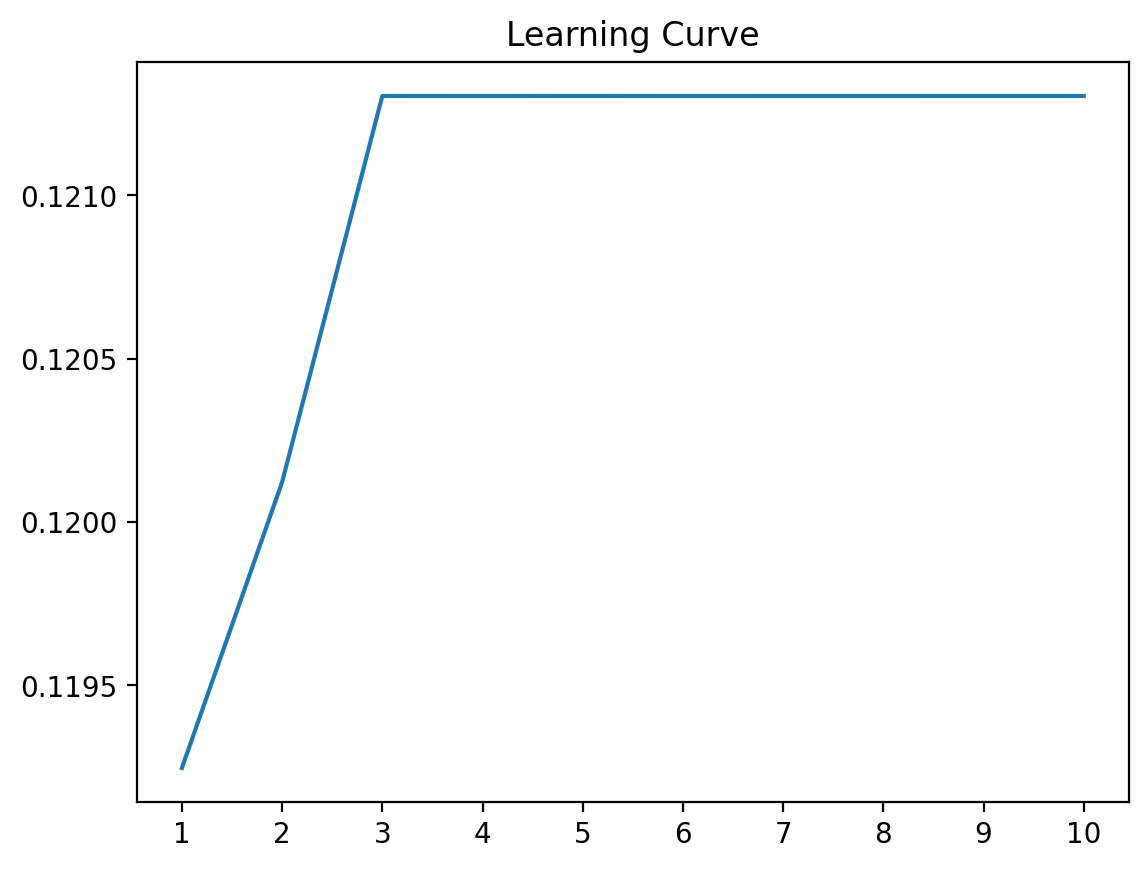

In [20]:
# The fit method returns a history object that
# can be used to plot the learning curve.

learning_curve = pd.Series(history.history['loss'])
learning_curve.index = learning_curve.index + 1

learning_curve.plot(title='Learning Curve')
plt.xticks(learning_curve.index)
plt.show()

In [21]:
import random
import tqdm

runs = 10
learning_rate_logs = [random.uniform(-5, 0) for _ in range(runs)]
encoder_widths = [random.choice(range(5, 20, 5)) for _ in range(runs)]
parameters = list(zip(learning_rate_logs, encoder_widths))

for (learning_rate_log, encoder_width) in tqdm.tqdm(parameters):
    with mlflow.start_run():
        autoencoder = build_model(encoder_width=encoder_width, learning_rate_log=learning_rate_log)
        history = train_anomaly_model(autoencoder, epochs=10, verbose=0)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:53<00:00, 11.31s/it]


In [22]:
# This loads the last active run,
# but you probably want to load the best run from the experiment.
last_run = mlflow.last_active_run()
saved_model_path = mlflow.tracking.MlflowClient().download_artifacts(last_run.info.run_id, 'model')
autoencoder = load_model(saved_model_path)

In [23]:
# Now we can feed the noisy images into the autoencoder.
train_denoised_X = autoencoder.predict(train_noisy_X)

# Keras returns back a Numpy array, but we need Pandas dataframe,
# so let's quickly put the denoised images into a dataframe.
train_denoised_X = pd.DataFrame(train_denoised_X)

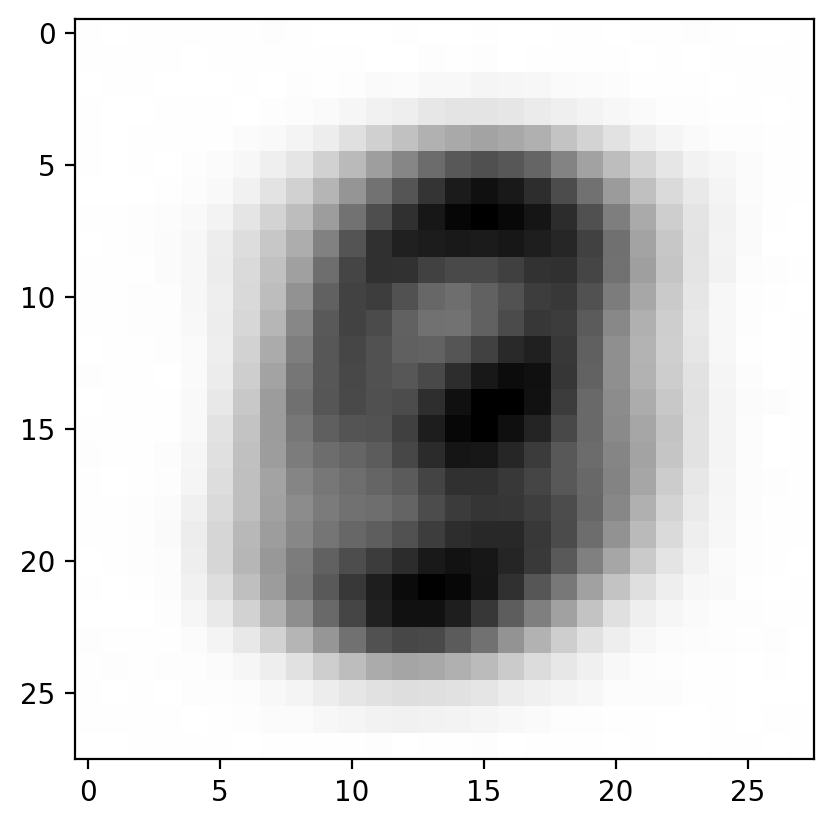

In [24]:
# Let's confirm that the denoiser works.
image_pixels = train_denoised_X.iloc[example_id]

# In order to plot an image, you need to reshape
# the array into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')
plt.show()

In [25]:
# To calculate MSE between two datasets we can use scikit-learn:
# https://scikit-learn.org/stable/
from sklearn.metrics import mean_squared_error

# This calcualates MSE on train clean against train denoised,
# which measures how well the autoencoder denoises the training dataset.
# Note that you really want to calculate this metric on validate and/or test dataset.
# Don't let an overfitting model fool you into using it for the graded submission!
mean_squared_error(train_denoised_X, train_clean_X)

0.0683976

In [26]:
import os 

model_path = 'assignment_submission'

os.makedirs(model_path, exist_ok=True)

# Once you are ready to make the graded submission,
# run the autoencoder on the score noisy dataset.
score_denoised_X = pd.DataFrame(
    autoencoder.predict(score_noisy_X),
    # This is needed to save the file in Parquet format.
    columns=score_noisy_X.columns
)

# Now save it to disc as a Parquet file.
score_denoised_X.to_parquet(f'{model_path}/score_denoised_x.parquet')

save_model(autoencoder, model_path)

# You now have the following files to be uploaded:
# 1. This notebook and any other Python code you used to train the final model.
# 2. architecture.json -- the model's definition
# 3. model.keras -- the model's trained parameters
# 4. score_denoised_X.parquet - the model's output on the score dataset